In [1]:
import open3d
import numpy as np
import util

import matplotlib.pyplot as plt

**1. Optimization**: You are given the function:  exp(-a * x) * sin(x) + b. Implement Levenberg Marquadt using numpy and solve for the parameters of the above function. Optimize for the following parameters: a=2, b = 1. Do this for 50 observations that lie between 1 and 20. Plot the loss values over time and data fit curves. Ensure that your initial estimates are not very close to the final parameters. Write down the jacobian formula in the notebook. **\[3 points\]**

$$
\begin{align}
J &= \begin{bmatrix} -xe^{-ax}sin(x) & 0 \\ 0 & 1 \\ \end{bmatrix}
\end{align}
$$

In [2]:
class Optimizer:
    def __init__(
        self,
        func_name,
        x_obs,
        y_obs,
        coeff,
        lr=1e-2,
        max_iter=200,
        tol=1e-15,
        lambda_=1.0,
    ):

        self.func_name = func_name
        self.func = eval(func_name)
        self.x_obs = x_obs
        self.y_obs = y_obs

        self.init_guess = coeff
        self.coeff = coeff
        self.num_params = len(coeff)

        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol

        self.lambda_ = lambda_

        self.h = 1e-4

        self.loss = []

        self.method = "Levenberg Marquardt"

    def get_residual(self, coeff):
        y_pred = self.func(self.x_obs, coeff)
        return y_pred - self.y_obs

    def get_jacobian(self):
        r = self.get_residual(self.coeff)

        jacobian = []
        for i, param in enumerate(self.coeff):
            coeff = self.coeff.copy()
            coeff[i] += self.h
            r_h = self.get_residual(coeff)
            partial_derv = (r_h - r) / self.h
            jacobian.append(partial_derv)
        jacobian = np.array(jacobian).T

        return jacobian

    def levenberg_marquardt(self):
        self.method = "Levenberg Marquardt"

        prev_error = 1e9
        for _ in range(self.max_iter):
            J = self.get_jacobian()
            R = self.get_residual(self.coeff)

            delta = (
                np.linalg.inv(J.T @ J + self.lambda_ * np.eye(self.num_params))
                @ J.T
                @ R
            )

            error = (R.T @ R) / 2

            if prev_error > error:
                self.coeff += -self.lr * delta
                self.lambda_ *= 0.9
            else:
                self.lambda_ *= 1.5

            loss = np.linalg.norm(R)
            self.loss.append(loss)

            if loss < self.tol:
                return self.coeff
        return self.coeff

In [3]:
def compute_non_linear(x, k):
    a, b = k
    y = np.exp(-a * x) * np.sin(x) + b
    return y

In [4]:
a_gt = 2
b_gt = 1
k_gt = np.array([a_gt, b_gt])

x_obs = np.linspace(1, 20, num=50)
y_obs = compute_non_linear(x_obs, k_gt)

In [5]:
init_coeff = np.array([10, 30.0])

optimizer = Optimizer(
    "compute_non_linear", x_obs, y_obs, init_coeff, 
    lr=0.09, lambda_=0.1, max_iter=200
)

## Gradeint Descent
coeff = optimizer.levenberg_marquardt()
print(f"Final Gradient Descent parameters: {coeff}")

Final Gradient Descent parameters: [2.00005159 1.00000054]


In [6]:
y_pred = compute_non_linear(x_obs, coeff)
error = np.linalg.norm(y_pred - y_obs)
print(f"Error between predicted and actual observations: {error}")

Error between predicted and actual observations: 7.814143017608493e-06


Text(0.5, 1.0, 'Loss Curve')

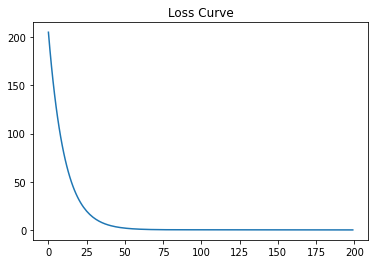

In [7]:
plt.plot(optimizer.loss)
plt.title('Loss Curve')

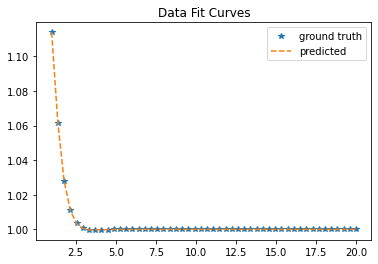

In [8]:
plt.plot(x_obs, y_obs, '*', label='ground truth')
plt.plot(x_obs, y_pred, '--', label='predicted')
plt.legend()
plt.title("Data Fit Curves")
plt.show()

**2. Linear least square**: You are given a bin file from the Kitti raw sequence. Estimate the ground plane from the given bin file. After estimating the ground plane, visualize this in open3d by drawing 200-300 points on the ground with a different color on top of the plot obtained from the LiDAR scan. Use RANSAC to estimate the ground plane. Will this work without RANSAC? Why or Why not? Write down the equation of the ground plane obtained and also mention the parameters used for doing RANSAC  **\[6 points\]**

Expected result is displayed here:

![output](./data/groundplane.png)

In [9]:
def read_bin_file(file_name):
    """
    Read the bin file
    """
    points = np.fromfile(file_name, dtype=np.float32).reshape(-1, 4)
    points = points[:, :3]  # exclude reflectance values, becomes [X Y Z]
    points = points[1::5, :]  # remove every 5th point for display speed (optional)
    return points

In [10]:
filename = "./data/000013.bin"
points = read_bin_file(filename)

# Function used to visualize point clouds,
# takes a list of 3 x N numpy array as input and plots
util.visualize_pointclouds([points.T])

In [11]:
points.shape

(24556, 3)

In [12]:
def ransac(data, min_points=3, max_iter=500, threshold=0.9, required_points=1000):
    n = data.shape[0]
    itr = 0
    best_err = 1e9
    best_params = None
    ground_points = []

    while itr < max_iter:
        rand_indices = np.random.choice(data.shape[0], min_points)
        rand_points = data[rand_indices]

        b = rand_points[:, 2]

        estimated_params = np.linalg.pinv(np.delete(rand_points, 2, 1)) @ b

        plane_points = []
        remaining_data = data[[i for i in range(n) if i not in rand_indices]]
        for point in remaining_data:
            b_hat = np.delete(point[None], 2, 1) @ estimated_params
            if np.linalg.norm(b_hat - b) < threshold:
                plane_points.append(point)
        plane_points = np.array(plane_points)

        if len(plane_points) > required_points:
            combined_data = np.vstack((rand_points, plane_points))

            b = combined_data[:, 2]

            new_params = np.linalg.lstsq(np.delete(combined_data, 2, 1), b, rcond=None)[
                0
            ]

            b_hat = np.delete(combined_data, 2, 1) @ new_params
            error = np.linalg.norm(b_hat - b)
            if error < best_err:  # and len(combined_data) > len(ground_points):
                print(
                    f"Iteration {itr}: Found better params!! {error}, total_points: {combined_data.shape[0]}"
                )
                best_err = error
                best_params = new_params, b.mean()
                # ground_points = combined_data
        itr += 1

    b = []
    for point in data:
        b_hat = np.delete(point[None], 2, 1) @ best_params[0]
        if np.linalg.norm(b_hat - point[2]) < threshold:
            ground_points.append(point)
            b.append(point[2])
    ground_points = np.array(ground_points)
    b = np.array(b)

    best_params = (best_params[0], b)

    return best_params, ground_points[:, :-1]

In [13]:
homo_points = np.hstack([points, np.ones((points.shape[0], 1))])

In [14]:
model_params, ground_points = ransac(homo_points)

Iteration 0: Found better params!! 41.990273897867624, total_points: 11287
Iteration 21: Found better params!! 31.18941007849336, total_points: 2346
Iteration 40: Found better params!! 17.462838955302097, total_points: 2366
Iteration 226: Found better params!! 11.347619659732537, total_points: 1031
Iteration 351: Found better params!! 8.073695823747432, total_points: 1386


In [15]:
min_pts = np.min(points, axis=0)
max_pts = np.max(points, axis=0)

In [16]:
B = model_params[1]
B.std(), B.mean()

(0.4744095581426903, -1.6868524990941254)

In [17]:
x_range = np.linspace(min_pts[0], max_pts[0], 20)
y_range = np.linspace(min_pts[1], max_pts[1], 20)

X, Y = np.meshgrid(x_range, y_range, sparse=False)

a, b, c = model_params[0]

Z = a * X + b * Y + c

X_flatten = X.flatten()
Y_flatten = Y.flatten()
Z_flatten = Z.flatten()

plane_pts = np.vstack((X_flatten, Y_flatten, Z_flatten))

In [18]:
util.visualize_pointclouds([points.T, plane_pts, ground_points.T])

In [19]:
print(f'Equation of Plane is: {a:.3f}x + {b:.3f}y + {c:.3f} = z')

Equation of Plane is: 0.021x + 0.019y + -1.716 = z


Yes, this will work without RANSAC. A simple Least Squares Formulation will also yield the best fitting plane. The equation of ground truth plane obtained is $~0.021x - 0.019y - 1.716 = z$. Parameters used for RANSAC are min_points (minimum points to estimate plane parameters), threshold (to determine data points that are lying near plane), required_points (number of close data points required to verify that plane fits well to data).

![](./gt_plane_pcd.png)